# Partie II - Evolution temporelle

Ici, on utilise l'algorithme d'Euler explicite pour obtenir l'évolution temporelle de la fonction d'onde. Cet algorithme, bien que simple à utiliser, n'est pas très efficace.

Lors de la partie 1, on utilisait un Hamiltonien à valeurs réelles, ici nous sommes obligés d'utiliser des valeurs complexes.

Imaginons que l'on obtienne un hamiltonien complexe $\psi(x)$ sous la forme d'un array numpy

In [42]:
import numpy as np
import matplotlib.pyplot as plt


# On définit d'abord les constantes dx et dt.
N = 100
L = 5
dx = L/N

M = 1000000
T = 1
dt = T/M

# Puis x tel que 

x = np.linspace(-L,L,N)

On réitère ensuite la formation d'un hamiltionien vu lors de la partie 1 pour un potentiel nul

In [43]:
V = np.zeros(N) #potentiel nul

def get_matrice(V):

    d = np.zeros(N)
    e= np.zeros(N-1)

    for i in range(V.size):
        d[i] = 2/(dx**2) + V[i]

    for i in range(e.size):
        e[i] = -1/(dx**2)
        
    return d,e

d,e = get_matrice(V)

from scipy.linalg import eigh_tridiagonal

## Puis, on calcule w et v respectivement les valeurs propres et vecteurs propres de H

w, v = eigh_tridiagonal(d,e)

# On doit désormais normaliser les vecteurs propres :

def normalize(m, dx):
    m /= np.linalg.norm(m,axis=0)
    m /= np.sqrt(dx)
    return m

# On crée la fonction pour former psi à partir de V (dans le cas où V n'est plus le même)

def get_psi(V):
    d,e = get_matrice(V)
    
    w, v = eigh_tridiagonal(d,e)
    
    for vec in v:
        normalize(v,dx)
    v0 = np.zeros((N,N))
    for i in range(N):
        for y in range(N):            #On échange ligne et colonnes
            v0[i][y] = v[y][i]
    
    return w,v0

w,v = get_psi(V)


Puis, on forme la matrice H complète à partir de ses valeurs tridiagonale

In [44]:
H = np.zeros((N,N),dtype=complex)

# on ajoute les valeurs dans H
for i in range(N):
    H[i][i] += d[i]
    if(i != N-1):
        H[i][i+1] += e[i]
        H[i+1][i] += e[i]

print(H)

[[ 800.+0.j -400.+0.j    0.+0.j ...    0.+0.j    0.+0.j    0.+0.j]
 [-400.+0.j  800.+0.j -400.+0.j ...    0.+0.j    0.+0.j    0.+0.j]
 [   0.+0.j -400.+0.j  800.+0.j ...    0.+0.j    0.+0.j    0.+0.j]
 ...
 [   0.+0.j    0.+0.j    0.+0.j ...  800.+0.j -400.+0.j    0.+0.j]
 [   0.+0.j    0.+0.j    0.+0.j ... -400.+0.j  800.+0.j -400.+0.j]
 [   0.+0.j    0.+0.j    0.+0.j ...    0.+0.j -400.+0.j  800.+0.j]]


On forme ensuite une liste de liste psi\[t\]\[x\] représentant toutes les valeurs de v (le vecteur de psi) pour tout t

In [45]:
psi = np.zeros((M,N),dtype=complex)

#On pose un p défini qui représente l'énergie dans laquelle on se place

p = 0

for i in range(N):
    psi[0][i] = v[i][p]
psi[0] = normalize(psi[0],dx)
print(psi)

[[ 0.01957167+0.j -0.0391244 +0.j  0.05863928+0.j ...  0.05863928+0.j
   0.0391244 +0.j -0.01957167+0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]]


Enfin, on utilise la formule (7) du poly ce qui nous donne les valeurs de psi pour différents temps :

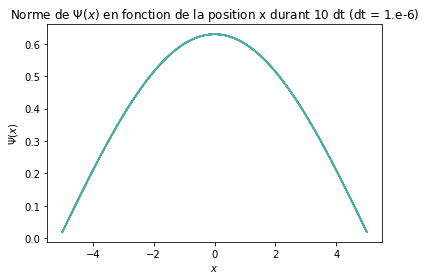

In [46]:
def pass_time(psi,H):
    for i in range(M-1):
        psi[i+1] = psi[i] - dt*np.matmul(1j*H,psi[i])
        psi[i+1] = normalize(psi[i+1],dx)
    
# On crée la fonction pour afficher les graphiques

dt_approx = np.format_float_scientific(dt, precision = 1, exp_digits=1)

def get_graph(v,name,nb_dt):
    normev = np.abs(v)
    for i in range(nb_dt):
        plt.plot(x,normev[i],label="Numérique $t=%i \cdot dt$" %i)
    plt.xlabel('$x$')
    plt.ylabel('$\Psi(x)$')
    plt.title('Norme de $\Psi(x)$ en fonction de la position x durant %i dt (dt = %s)' %(nb_dt,dt_approx))
    plt.savefig('docs/tempo/psi_fonction_de_x_%s_m%i_duree_%i.pdf' %(name,M,nb_dt),format='pdf')
    plt.savefig('docs/tempo/psi_fonction_de_x_%s_m%i_duree_%i.jpeg' %(name,M,nb_dt),format='jpeg')
    plt.show()

pass_time(psi,H)
get_graph(psi,"euler_etat_statio0",10)

Ici, nous allons reprendre le même processus mais avec un état initial sous forme d'un paquet d'onde d'une gaussienne

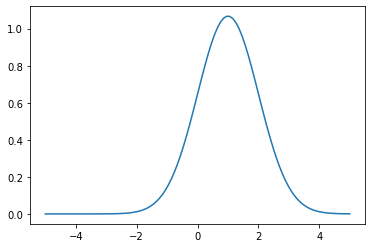

In [47]:
x0 = 1
sigma = 1

for i in range(N):
    inside_exp = -((x[i]-x0)**2)/(2*(sigma**2))
    psi[0][i] = np.exp(inside_exp)/(sigma*np.sqrt(2*np.pi))
    
psi[0] = normalize(psi[0],dx)


plt.plot(x,np.abs(psi[0]))
plt.show()

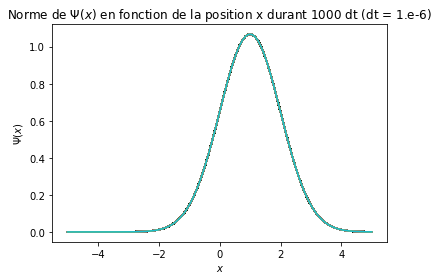

In [48]:
pass_time(psi,H)
get_graph(psi,"euler_gaussienne",1000)

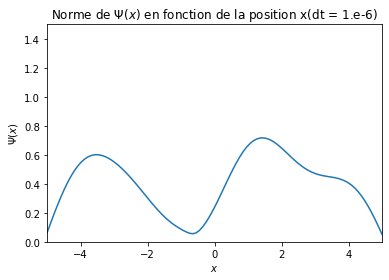

In [52]:
# ------------ ANIMATION -------------- #

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

metadata = dict(title='test', artist='lucas')
writer = PillowWriter(fps=1000, metadata=metadata)


fig = plt.figure()
plt.xlim(-L, L)
plt.ylim(0, 1.5)

plt.xlabel('$x$')
plt.ylabel('$\Psi(x)$')
plt.title('Norme de $\Psi(x)$ en fonction de la position x(dt = %s)' %(dt_approx))

l, = plt.plot(x,abs(psi[0]))



with writer.saving(fig, "docs/tempo/anim.gif", 1000):
    for y in psi[0:M:int(M/100)]:
        l.set_ydata(abs(y))
        writer.grab_frame()

# ------------ FIN ANIMATION -------------- #

plt.show()

On remarque ici que notre rendu n'est pas correct, ou alors est trop long. En effet l'algorithme d'Euler explicite ne nous permet pas d'être suffisament précis, nous allons donc mettre en oeuvre l'algorithme de Runge-Kutta d'ordre 4

### Sources :
 - https://www.f-legrand.fr/scidoc/docmml/numerique/euler/euler/euler.html
 - https://www.youtube.com/watch?v=tsK72kSgPoI
 - https://www.moonbooks.org/Articles/How-to-create-a-matrix-of-complex-numbers-in-python-using-numpy-/
 - https://femto-physique.fr/analyse-numerique/runge-kutta.php